# Homework 9: Scikit-Image

Due April 28th at 8pm

## Asteroid tracking

Complete the asteroid tracking breakout from class.

What worked well, what went wrong, and what approaches could help in a real-world scenario to improve results?


COME BACK AND FINISH

### Answer:

In [225]:
# Imports
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
%matplotlib inline
plt.style.use('default')
mpl.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 18})



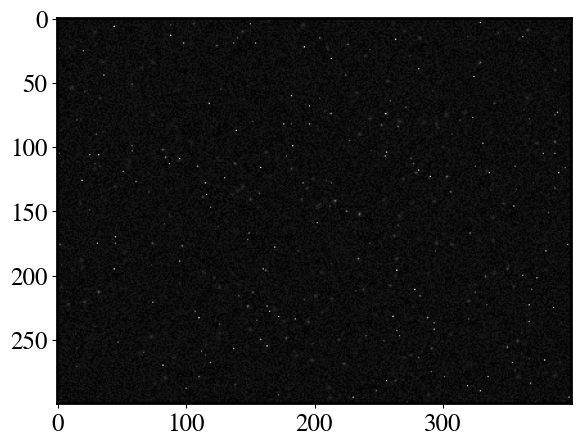

In [226]:
frames = ski.io.ImageCollection('Data/asteroid_*.png')
plt.figure(figsize=(8, 5))
plt.imshow(frames[0], cmap="gray")
plt.show()

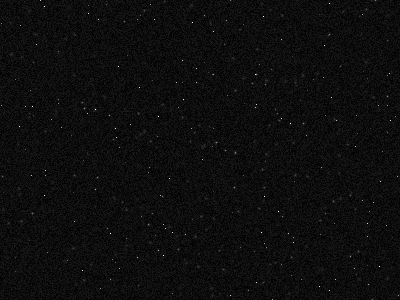

In [227]:
from IPython.display import Image
Image('Data/asteroid.gif', width=400)

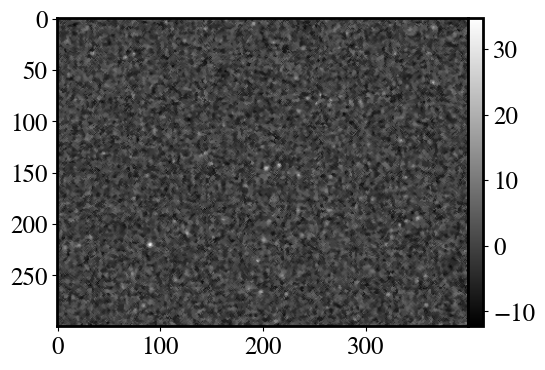

In [228]:
from skimage.morphology import disk

#apply a filter that takes the median using a disk window kernel
medians = [ski.filters.median(frame, disk(2)) for frame in frames] 

plt.figure(figsize=(7,4))
#subtract off the mean and plot to see the asteroid better
plt.imshow(medians[3] - np.mean(frames),cmap="gray")
plt.colorbar(pad=0)
plt.show()

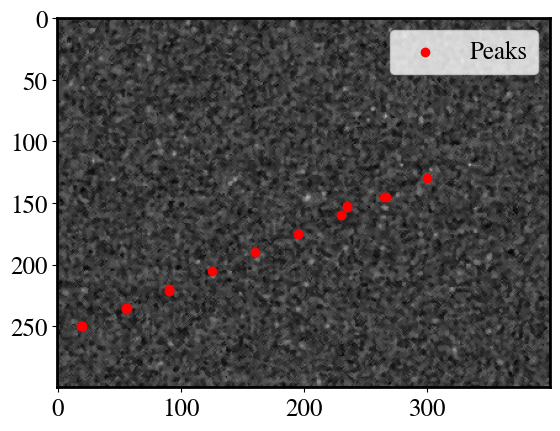

In [230]:
#--------------------------------------------------------

all_peaks = []
mean_frame_value = np.mean(frames)
for frame in medians[1:]:
    subtraction = frame - mean_frame_value
    
    #returns list of [x,y] for all peaks in frame
    peaks_in_frame = ski.feature.peak_local_max(subtraction, threshold_rel=0.8) 
    all_peaks.extend(peaks_in_frame.tolist())
    
#--------------------------------------------------------
    
all_peaks = np.reshape(all_peaks, (-1, 2)) #reshape to an array

#use RANSAC from lecture to fit all the points to 1D line and pull out the inliers
model, inliers = ski.measure.ransac(all_peaks[:, ::-1],
                                    ski.measure.LineModelND,
                                    min_samples=2,
                                    residual_threshold=1)

plt.imshow(delta, cmap="gray")
plt.scatter(all_peaks[:, 1], all_peaks[:, 0], color='r', marker='o', label="Peaks")
plt.legend()
plt.show()

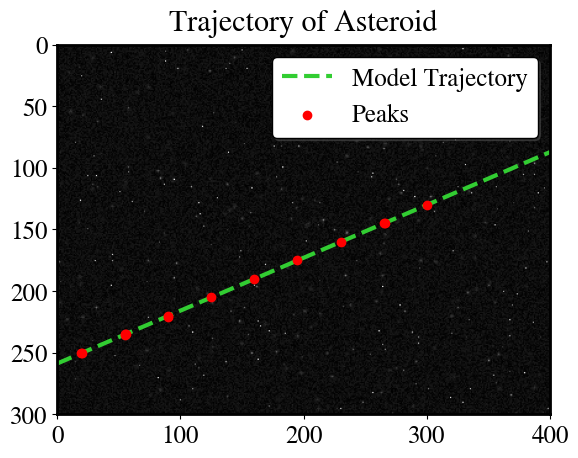

In [258]:
plt.imshow(frames[0],cmap="gray")

trajectory = all_peaks[inliers] #pull out only the inliers to the model

x = np.linspace(0, delta.shape[1], 100)
plt.plot(x, model.predict_y(x), linewidth=3, 
         color="limegreen",linestyle="--", label="Model Trajectory")
plt.scatter(trajectory[:, 1], trajectory[:, 0], 
            color='red', marker='o', zorder=5, label="Peaks")
plt.legend(shadow=True, edgecolor="black")
plt.xlim(0,400)
plt.ylim(300,0)
plt.title("Trajectory of Asteroid", pad=10)
plt.show()

**Answer:** This approach is very sensitive to choice of relative threshold in the local max finder. 

# Panorama Stitching

**Question:** One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb). Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

**Answer:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()
    

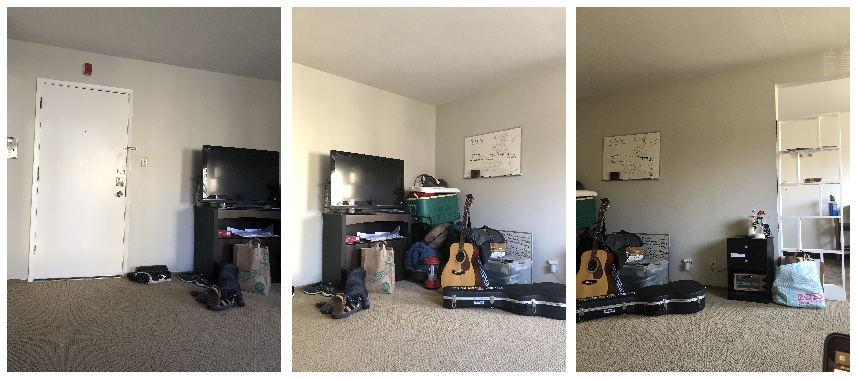

In [2]:
pano_imgs = io.ImageCollection('Images2/*.jpg')

compare(*pano_imgs, figsize=(12, 10))

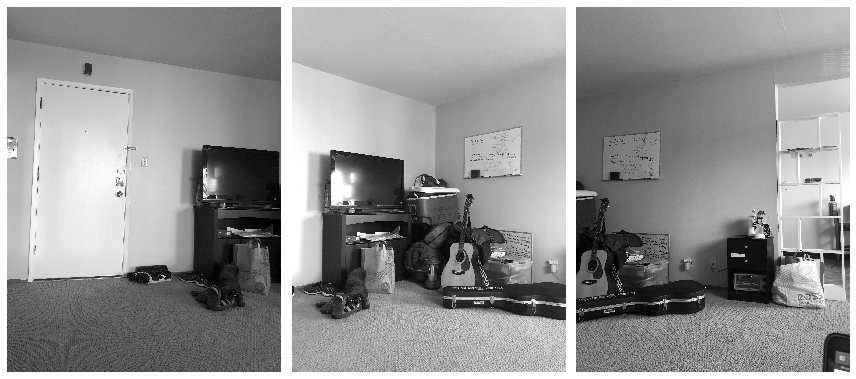

In [3]:
from skimage.color import rgb2gray

pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]
# View the results
compare(pano0, pano1, pano2, figsize=(12, 10))

#### Detect Features and Anchor Points

In [4]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

In [5]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

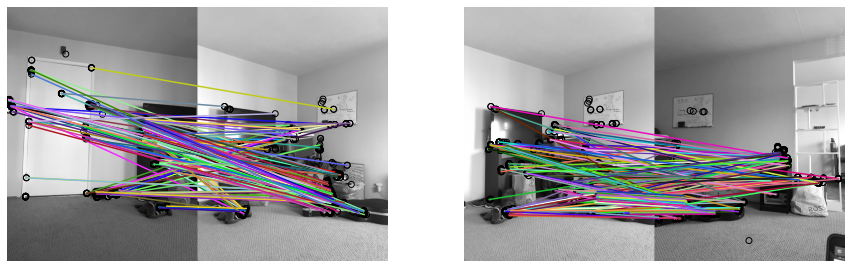

In [6]:
from skimage.feature import plot_matches
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Best match subset for pano0 -> pano1
plot_matches(axes[0], pano0, pano1, keypoints0, keypoints1, matches01)
plot_matches(axes[1], pano1, pano2, keypoints1, keypoints2, matches12)
axes[0].axis('off');
axes[1].axis('off');

#### Transform Estimation for Images using RANSAC

In [7]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

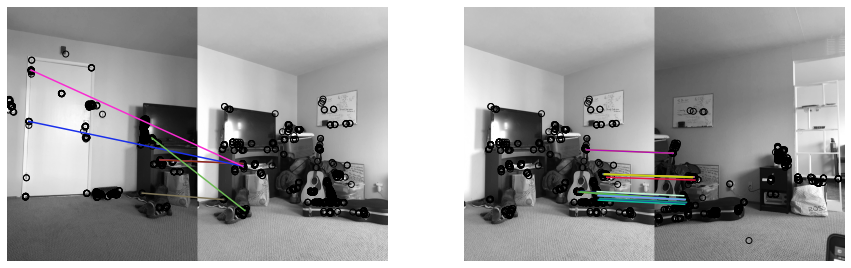

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Best match subset for pano0 -> pano1
plot_matches(axes[0], pano0, pano1, keypoints0, keypoints1, matches01[inliers01])
plot_matches(axes[1], pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

axes[0].axis('off');
axes[1].axis('off');

#### Warping

In [9]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [10]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

In [11]:
# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [12]:
# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

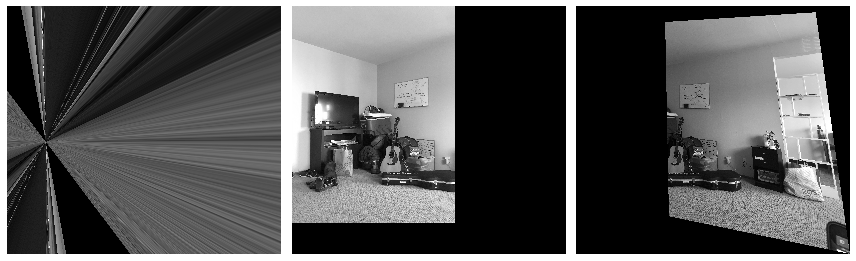

In [13]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

#### Combine Warped Images

In [17]:
rmax = output_shape[0] - 1
cmax = output_shape[1] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    cmax // 3],
              [rmax, cmax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*cmax // 3],
              [rmax, 2*cmax // 3]]


from skimage.morphology import flood_fill

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.

    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.

    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T

    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)

    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()
    shape = mask.shape

    # Label discrete regions
    labels = mask.copy().astype(np.uint8)
    cslice = slice(cmin, cmax + 1)
    submask = np.ascontiguousarray(labels[:, cslice])
    submask = flood_fill(submask, (0, 0), 2)
    submask = flood_fill(submask, (shape[0]-1, 0), 3)
    labels[:, cslice] = submask

    # Find distance from edge to region
    upper = (labels == 2).sum(axis=0).astype(np.float64)
    lower = (labels == 3).sum(axis=0).astype(np.float64)

    # Reject areas of high change
    ugood = np.abs(np.gradient(upper[cslice])) < gradient_cutoff
    lgood = np.abs(np.gradient(lower[cslice])) < gradient_cutoff

    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper)
    costs_lower = np.ones_like(lower)
    costs_upper[cslice][ugood] = upper[cslice].min() / np.maximum(upper[cslice][ugood], 1)
    costs_lower[cslice][lgood] = lower[cslice].min() / np.maximum(lower[cslice][lgood], 1)

    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)

    # Place these in output array
    costs_arr[:, cslice] = costs_upper[:, cslice] * (labels[:, cslice] == 2)
    costs_arr[:, cslice] +=  costs_lower[:, cslice] * (labels[:, cslice] == 3)

    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]

    return costs_arr

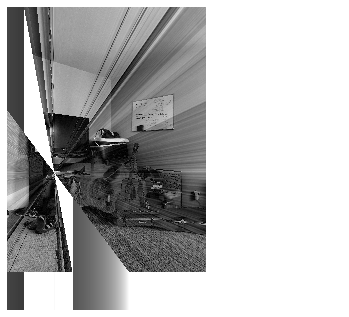

In [18]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

costs01[0,  :] = 0
costs01[-1, :] = 0

fig, ax = plt.subplots(figsize=(6,8))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');

In [ ]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

In [ ]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');


In [ ]:
from skimage.morphology import flood_fill

# Labeling starts with one at point (0, 0)
mask0 = flood_fill(mask0, (0, 0), 1, connectivity=1)

# The result
plt.imshow(mask0, cmap='gray');

In [ ]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

costs12[mask0 > 0] = 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

In [ ]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

In [ ]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

mask2 = flood_fill(mask2, (rmax, cmax), 1, connectivity=1)

mask1 = ~(mask0.astype(np.bool) | mask2.astype(np.bool))

# The result
plt.imshow(mask2, cmap='gray');

In [ ]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

In [ ]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

## Image Stacking

Stack several photos of the night sky to reveal its structure. Here are some datasets you can use:

- https://chandra.harvard.edu/photo/openFITS/
- https://esahubble.org/projects/fits_liberator/m17data/
- https://www.photographingspace.com/homework-download-stack-data/
- https://www.astropix.com/html/processing/practice_files.html
- https://www.astrobin.com/forum/c/astrophotography/other/all-my-raw-files-are-or-will-be-public-online/

(While you should use Python code to do the stacking, you can also compare your results to those obtained using dedicated software such as https://siril.org/.)

In [50]:
from astropy.io import fits
import skimage as skimg

with fits.open("Stack/casa_0.5-1.5keV.fits") as hdul:
    hdul.verify('fix')
    data_red = hdul[0].data
    
with fits.open("Stack/casa_1.5-3.0keV.fits") as hdul:
    hdul.verify('fix')
    data_green = hdul[0].data
    
with fits.open("Stack/casa_4.0-6.0keV.fits") as hdul:
    hdul.verify('fix')
    data_blue = hdul[0].data

In [167]:
data = (np.array([data_red, data_green, data_blue])).T
data = data / np.max(data, axis=(0,1)) #normalize data to 0-1

#experiment with adjusting exposure to make the image brighter/prettier
data = skimg.exposure.adjust_gamma(data, gamma=0.75, gain=1) 
data_bright = skimg.exposure.rescale_intensity(data, in_range=(0.0,0.3), out_range=(0.0,1.0))


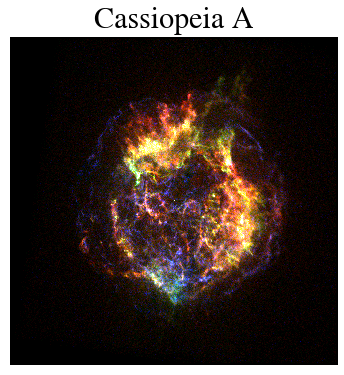

In [168]:
plt.figure(figsize=(6,6))
plt.title("Cassiopeia A", fontsize=30, pad=10)
plt.imshow(data_bright, interpolation="nearest")
plt.xticks([])
plt.yticks([])
plt.show()
